<a href="https://colab.research.google.com/github/ZitongZhou/react_inverse/blob/master/react_trans_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pytorch model for the reaction eqn 10*20 contaminant flow prediction

In [0]:
# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass

In [0]:
import pickle as pk
import numpy as np
from matplotlib import ticker, cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import tensorflow as tf
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, MultiStepLR
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
from google.colab import files
import time
from time import sleep
from IPython.display import clear_output
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


load the training data

In [7]:
with open('/content/drive/My Drive/inverse_modeling/reactive_transport/net_files/sources','rb') as file:  
  [N_inits] = pk.load(file, encoding='latin1')
print('pickle loaded the sources')

pickle loaded the sources


In [5]:
with open('/content/drive/My Drive/inverse_modeling/reactive_transport/net_files/1500samples','rb') as file:
  [x_ind, x, q, mod_wels, con_rate, N_obs, N_maps] = pk.load(file)
print('pickle loaded N_maps')

pickle loaded N_maps


turn the pickled list into dataset

In [8]:
print('sources:',np.asarray(N_inits).shape)
print('CTS:',np.asarray(N_maps).shape)
print('sensors:', np.asarray(N_obs).shape)

sources: (1500, 10, 41, 81)
CTS: (1500, 50, 41, 81)
sensors: (1500, 50, 20)


sensor locations, check if the N_obs are correct:

In [0]:
y_wel = np.array([6, 13, 20, 27, 34,
        6, 13, 20, 27, 34,
        6, 13, 20, 27, 34,
        6, 13, 20, 27, 34])# #np.random.randint(low = 5, high = 35, size = 20)
x_wel = np.array([1, 1, 1, 1, 1, 
         7, 7, 7, 7, 7,
         13, 13, 13, 13, 13,
         20, 20, 20, 20, 20])# #np.random.randint(low = 0, high = 25, size = 20)
         
np.random.seed(888)
y_obs = np.random.randint(low = 5, high = 35, size = 20)
x_obs = np.random.randint(low = 30, high = 80, size = 20)

In [67]:
ind = np.random.randint(0, 1500, 1)
print(N_obs[int(ind)][0] == N_maps[int(ind)][0][(y_obs, x_obs)])
print('This should print all true')

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
This should print all true


#Visualization and random test on model

In [0]:
def simple_plot(self, c_map, title):
    nx = 81
    ny = 41
    Lx = 2500
    Ly = 1250

    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X,Y = np.meshgrid(x, y)
    fig, axs = plt.subplots(1,1)
#        axs.set_xlabel('x(m)')
#        axs.set_ylabel('y(m)')
    axs.set_xlim(0,Lx)
    axs.set_ylim(0,Ly)
    c01map = axs.imshow(c_map, cmap='jet',
              extent=[x.min(), x.max(), y.min(), y.max()],
              vmin=c_map.min(), vmax = c_map.max(),
              origin='lower')
    fig.colorbar(c01map, ax=axs,shrink=0.62)
    name = title + '.pdf'
    plt.title(title)
#         fig.savefig('images/'+name, format='pdf',bbox_inches='tight')
    plt.show()
    return

def make_movie(maps, title = ''):   
    nx = 81
    ny = 41
    Lx = 2500
    Ly = 1250
    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X,Y = np.meshgrid(x, y)

    fig, axs = plt.subplots()
    #        axs.set_xlabel('x(m)')
    #        axs.set_ylabel('y(m)')
    axs.set_xlim(0,Lx)
    axs.set_ylim(0,Ly)
    times = list(np.arange(2, 21, 2)) + list(np.arange(20.5, 40.1, 0.5))
    for i in range(len(maps)):
        c_map = maps[i]
        c01_map = plt.imshow(c_map, cmap='jet',
              extent=[x.min(), x.max(), y.min(), y.max()],
              vmin=c_map.min(), vmax = c_map.max(),
              origin='lower')
#             fig.colorbar(c01_map, ax=axs, shrink=0.62)
        plt.title(title + "year {}".format(times[i]))
        plt.show()
        # Note that using time.sleep does *not* work here!
        sleep(0.1)
        clear_output(wait=True)


def vis_sensors(sensor):
    fig = plt.figure()
    for i in range(len(sensor[0])):
        sen = [None]*len(sensor)
        for j in range(len(sensor)):
            sen[j] = sensor[j][i]
        ax = fig.add_subplot(4,5,i+1)
        ax.plot(sen)
        ax.set_title('sensor' + str(i))
    
    plt.tight_layout()
    plt.show()


def vis_senmap(c,sensors_x,sensors_y):
    c = np.reshape(c,(40,80))
    x = np.linspace(0,20,80)
    y = np.linspace(0,10,40)
    X,Y = np.meshgrid(x,y)
    fig, axs = plt.subplots(1,1)
    c01map = axs.imshow(c, cmap='jet',
              extent=[x.min(), x.max(), y.min(), y.max()],
              vmin=np.min(c), vmax = np.max(c),
              origin='lower')
    axs.set_title('concentration map')
    fig.colorbar(c01map, ax=axs,shrink=0.62)
    axs.scatter(sensors_x,sensors_y, c = "red", label='sensors')
    plt.legend(loc=2)
    plt.show()
#    fig.savefig("sensors.eps", format='eps')
    

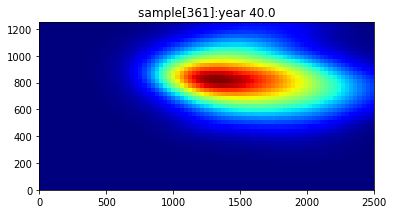

In [14]:
#randomly choose a test case to play the movie
ind = np.random.randint(0, 1500, 1)
make_movie(N_maps[int(ind)],'sample'+str(ind)+':')

In [0]:
def random_test(model):  
  #randomly choose a test sample to compare the target and output
  ind = np.random.randint(0,len(X_test)-1,1)
  tein = X_test[ind,:]
  tetar = y_test[ind,:]
  # if USE_GPU == True:
  #     tein = tein.cuda()
  start = time.time()
  teout = model(tein,training=False)
  end = time.time()

  mtime = end - start
  print('each modeling time is',mtime)
  # if USE_GPU == True: #each modeling time is 0.0008425712585449219
  #     teout = teout.numpy()
  #     tein = tein.numpy()
  print('relative test loss is',relaloss(teout,tetar))
  # tein  = tein.numpy() 
  teout = teout.numpy()
  # tetar = tetar.numpy()

  t1 = 'c0'
  t2 = 'cT_numerical'
  t3 = 'cT_NN'
  for i in range(11):
    t1 = 'c0'
    t2 = 'c' + str(i) + 'PDE solver'
    t3 = 'c' + str(i) + 'NN solver'
    vis3(tein,tetar[0,:,i],teout[0,:,i],t1,t2,t3)

#load data

In [0]:
def load_c(num_training, num_validation, num_test):
  """
  load training data from the pickled list: C0s, CTs, sensors, divide the training, validation, and num_test to 7:1.5:1.5
  """
  # turn C0s, CTs, as samples
  # X_train = C0s
  # y_train = output
  # X_train = np.asarray(X_train, dtype=np.float32)
  # y_train = np.asarray(y_train, dtype=np.float32)
  # y_train = np.transpose(y_train, (0,2,1))

  # Subsample the data
  tensor_X = torch.stack([torch.Tensor(np.reshape(i,(10,41,81))) for i in N_inits]) # transform to torch tensors
  tensor_y = torch.stack([torch.Tensor(np.reshape(i,(50,41,81))) for i in N_maps])

  train_size = num_training
  val_size = num_training + num_validation
  test_size = num_training + num_validation + num_test
  X_train = tensor_X[:train_size]
  y_train = tensor_y[:train_size]
  X_val = tensor_X[train_size:val_size]
  y_val = tensor_y[train_size:val_size]
  x_test = tensor_X[val_size:test_size]
  y_test = tensor_y[val_size:test_size]

  train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
  train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=40,shuffle=True)

  val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
  val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=50)

  test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
  test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=50)
  
  x_test = np.asarray(x_test, dtype=np.float32)
  y_test = np.asarray(y_test, dtype=np.float32)
  return train_loader, val_loader, x_test, y_test, test_loader

train_loader, val_loader, x_test, y_test, test_loader = load_c(num_training=1000, num_validation=0, num_test=500)

In [16]:
print('samples in test:', len(x_test))
print('dim of sample input', x_test[0].shape)
print('samples in test:', len(y_test))
print('dim of sample output', y_test[0].shape)

samples in test: 500
dim of sample input (10, 41, 81)
samples in test: 500
dim of sample output (50, 41, 81)


In [0]:
n_out_pixels_train = len(train_loader.dataset) * train_loader.dataset[0][1].numel()
n_out_pixels_test = len(test_loader.dataset) * test_loader.dataset[0][1].numel()

Use GPU for training

In [18]:
torch.cuda.is_available()

True

In [19]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


# c0[3200,] --> cT[10,3200]


### dense blocks

In [0]:
class _DenseLayer(nn.Sequential):
    # bottleneck layer, bn_size: bottleneck size
    def __init__(self, in_features, growth_rate, drop_rate=0, bn_size=4,
                 bottleneck=False):
        # detect if the input features are more than bn_size x k,
        # if yes, use bottleneck -- not much memory gain, but lose one relu
        # I disabled the bottleneck for current implementation
        super(_DenseLayer, self).__init__()
        if bottleneck and in_features > bn_size * growth_rate:
            self.add_module('norm1', nn.BatchNorm2d(in_features))
            self.add_module('relu1', nn.ReLU(inplace=True))
            self.add_module('conv1', nn.Conv2d(in_features, bn_size *
                            growth_rate, kernel_size=1, stride=1, bias=False))
            self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                            kernel_size=3, stride=1, padding=1, bias=False))
        else:
            self.add_module('norm1', nn.BatchNorm2d(in_features))
            self.add_module('relu1', nn.ReLU(inplace=True))
            self.add_module('conv1', nn.Conv2d(in_features, growth_rate,
                            kernel_size=3, stride=1, padding=1, bias=False))
        self.drop_rate = drop_rate

    def forward(self, x):
        y = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            y = F.dropout2d(y, p=self.drop_rate, training=self.training)
        z = torch.cat([x, y], 1)
        return z


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, in_features, growth_rate, drop_rate,
                 bn_size=4, bottleneck=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(in_features + i * growth_rate, growth_rate,
                                drop_rate=drop_rate, bn_size=bn_size,
                                bottleneck=bottleneck)
            self.add_module('denselayer%d' % (i + 1), layer)

class _Transition(nn.Sequential):
    def __init__(self, in_features, out_features, encoding=True, drop_rate=0.,
                 last=False, out_channels=3, outsize_even=True):
        super(_Transition, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(in_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        if encoding:
            # reduce feature maps; half image size (input feature size is even)
            # bottleneck impl, save memory, add nonlinearity
            self.add_module('conv1', nn.Conv2d(in_features, out_features,
                                              kernel_size=1, stride=1,
                                              padding=0, bias=False))
            if drop_rate > 0:
                self.add_module('dropout1', nn.Dropout2d(p=drop_rate))
            self.add_module('norm2', nn.BatchNorm2d(out_features))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('conv2', nn.Conv2d(out_features, out_features,
                                              kernel_size=3, stride=2,
                                              padding=1, bias=False))
            if drop_rate > 0:
                self.add_module('dropout2', nn.Dropout2d(p=drop_rate))
        else:
            # decoding, transition up
            if last:
                ks = 6 if outsize_even else 5
                out_convt = nn.ConvTranspose2d(out_features, out_channels,
                                kernel_size=ks, stride=2, padding=2, bias=False)
            else:
                out_convt = nn.ConvTranspose2d(
                    out_features, out_features, kernel_size=3, stride=2,
                    padding=1, output_padding=0, bias=False)

            # bottleneck impl, save memory, add nonlinearity
            self.add_module('conv1', nn.Conv2d(in_features, out_features,
                                              kernel_size=1, stride=1,
                                              padding=0, bias=False))
            if drop_rate > 0:
                self.add_module('dropout1', nn.Dropout2d(p=drop_rate))

            self.add_module('norm2', nn.BatchNorm2d(out_features))
            self.add_module('relu2', nn.ReLU(inplace=True))
            self.add_module('convT2', out_convt)
            if drop_rate > 0:
                self.add_module('dropout2', nn.Dropout2d(p=drop_rate))

class DenseED(nn.Module):
    def __init__(self, in_channels, out_channels, blocks, growth_rate=16,
                 num_init_features=64, bn_size=4, drop_rate=0, outsize_even=False,
                 bottleneck=False):
        """
        Args:
            in_channels (int): number of input channels
            out_channels (int): number of output channels
            blocks: list (of odd size) of integers
            growth_rate (int): K
            num_init_features (int): the number of feature maps after the first
                conv layer
            bn_size: bottleneck size for number of feature maps (not useful...)
            bottleneck (bool): use bottleneck for dense block or not
            drop_rate (float): dropout rate
            outsize_even (bool): if the output size is even or odd (e.g.
                65 x 65 is odd, 64 x 64 is even)
        """
        super(DenseED, self).__init__()
        self.out_channels = out_channels

        if len(blocks) > 1 and len(blocks) % 2 == 0:
            ValueError('length of blocks must be an odd number, but got {}'
                       .format(len(blocks)))
        enc_block_layers = blocks[: len(blocks) // 2]
        dec_block_layers = blocks[len(blocks) // 2:]
        self.features = nn.Sequential()
        # First convolution ================
        # only conv, half image size
        self.features.add_module('in_conv',
                    nn.Conv2d(in_channels, num_init_features,
                            kernel_size=7, stride=2, padding=3, bias=False))

        # Encoding / transition down ================
        # dense block --> encoding --> dense block --> encoding
        num_features = num_init_features
        for i, num_layers in enumerate(enc_block_layers):
            block = _DenseBlock(num_layers=num_layers,
                                in_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate,
                                drop_rate=drop_rate, bottleneck=bottleneck)
            self.features.add_module('encblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate

            trans = _Transition(in_features=num_features,
                                out_features=num_features // 2,
                                encoding=True, drop_rate=drop_rate)
            self.features.add_module('down%d' % (i + 1), trans)
            num_features = num_features // 2

        # Decoding / transition up ==============
        # dense block --> decoding --> dense block --> decoding --> dense block
        # if len(dec_block_layers) - len(enc_block_layers) == 1:
        for i, num_layers in enumerate(dec_block_layers):
            block = _DenseBlock(num_layers=num_layers,
                                in_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate,
                                drop_rate=drop_rate, bottleneck=bottleneck)
            self.features.add_module('decblock%d' % (i + 1), block)
            num_features += num_layers * growth_rate

            # if this is the last decoding layer is the output layer
            last_layer = True if i == len(dec_block_layers) - 1 else False

            trans = _Transition(in_features=num_features,
                                out_features=num_features // 2,
                                encoding=False, drop_rate=drop_rate,
                                last=last_layer, out_channels=out_channels,
                                outsize_even=outsize_even)
            self.features.add_module('up%d' % (i + 1), trans)
            num_features = num_features // 2

    def forward(self, x):
        y = self.features(x)

        # use the softplus activation for concentration
        y = F.softplus(y.clone(), beta=5)

        # in the example, pressure is the last output channel
        # use the sigmoid activation for pressure
        # y[:,self.out_channels-1] = torch.sigmoid(y[:,self.out_channels-1])

        return y

    def _num_parameters_convlayers(self):
        n_params, n_conv_layers = 0, 0
        for name, param in self.named_parameters():
            if 'conv' in name:
                n_conv_layers += 1
            n_params += param.numel()
        return n_params, n_conv_layers

    def _count_parameters(self):
        n_params = 0
        for name, param in self.named_parameters():
            print(name)
            print(param.size())
            print(param.numel())
            n_params += param.numel()
            print('num of parameters so far: {}'.format(n_params))

    def reset_parameters(self, verbose=False):
        for module in self.modules():
            # pass self, otherwise infinite loop
            if isinstance(module, self.__class__):
                continue
            if 'reset_parameters' in dir(module):
                if callable(module.reset_parameters):
                    module.reset_parameters()
                    if verbose:
                        print("Reset parameters in {}".format(module))

In [0]:
# in_channel = 1
# out_channel = 10
model = DenseED(10, 50, blocks=(8,16,8), growth_rate=40,
                drop_rate=0, bn_size=8,
                num_init_features=48, bottleneck=False).to(device)

In [70]:
print(F.l1_loss(output[:,:,y_obs, x_obs], target[:,:,y_obs, x_obs], reduction='sum'))
print(F.l1_loss(output[:,:,y_obs-1, x_obs], target[:,:,y_obs-1, x_obs], reduction='sum'))
print(F.l1_loss(output[:,:,y_obs+1, x_obs], target[:,:,y_obs+1, x_obs], reduction='sum'))
print(F.l1_loss(output[:,:,y_obs, x_obs-1], target[:,:,y_obs, x_obs-1], reduction='sum'))
print(F.l1_loss(output[:,:,y_obs, x_obs-1], target[:,:,y_obs, x_obs-1], reduction='sum'))

tensor(2191216., device='cuda:0', grad_fn=<L1LossBackward>)
tensor(2187215.5000, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(2154311.2500, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(2253612.5000, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(2253612.5000, device='cuda:0', grad_fn=<L1LossBackward>)


In [0]:
## load the trained model
# model.load_state_dict(torch.load('/content/drive/My Drive/inverse_modeling/Code/python_2d/nonlinear_10_20/model_epoch150.pth'))
# print('Loaded model')

Loaded model


In [24]:
## test input output dimension
tein, tetar = train_loader.dataset[0:1]
# tetar = y_test[ind,:]
if USE_GPU == True:
    tein = tein.cuda()
start = time.time()
teout = model(tein)
end = time.time()
print('shape of the output is correct? ', teout.shape == tetar.shape)
print('One model prediction takes ', end - start, 'second')

shape of the output is correct?  True
One model prediction takes  0.023434877395629883 second


In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10,
                    verbose=True, threshold=0.0001, threshold_mode='rel',
                    cooldown=0, min_lr=0, eps=1e-08)
num_test = 500

def test(epoch, plot_intv):
    model.eval()
    loss = 0.
    for batch_idx, (input, target) in enumerate(test_loader):
        input, target = input.to(device), target.to(device)
        with torch.no_grad():
            output = model(input)
        loss += F.mse_loss(output, target,reduction='sum').item()

        # plot predictions
        if epoch % plot_intv == 0 and batch_idx == len(test_loader) - 1:
            n_samples = 1
            idx = torch.LongTensor(np.random.choice(num_test, n_samples, replace=False))
            for i in range(n_samples):
                x = x_test[ [idx[i]] ]
                samples_target = y_test[ idx[i] ]
                x_tensor = (torch.FloatTensor(x)).to(device)
                y_hat = model(x_tensor)
                samples_output = y_hat[0].data.cpu().numpy()
                plot_pred(samples_target, samples_output, epoch, idx[i])

    rmse_test = np.sqrt(loss / n_out_pixels_test)
    # r2_score = 1 - loss / y_test_var
    print("epoch: {}, test rmse_test:  {:.6f}".format(epoch, rmse_test))
    return rmse_test

In [0]:
def plot_pred(samples_target, samples_output, epoch, idx):

    samples_err = samples_target - samples_output
    samples = np.vstack((samples_target, samples_output, samples_err))

    Nout = samples_target.shape[0]
    c_max = np.full( (Nout*3), 0.0)
    c_min = np.full( (Nout*3), 0.0)
    for l in range(Nout*3):
        if l < Nout:
            c_max[l] = np.max(samples[l])
        elif Nout <= l < 2*Nout:
            c_max[l] = np.max(samples[l])
            if c_max[l] > c_max[l-Nout]:
                c_max[l-Nout] = c_max[l]
            else:
                c_max[l] = c_max[l-Nout]
        else:
            c_max[l] = np.max( np.abs(samples[l]) )
            c_min[l] = 0. - np.max( np.abs(samples[l]) )

    LetterId = (['a','b','c','d','e', 'f','g','h','i','j', 'k','l','m','n','o'])
    ylabel = (['$\mathbf{y}$', '$\hat{\mathbf{y}}$', '$\mathbf{y}-\hat{\mathbf{y}}$'])
    fig = plt.figure(figsize=(4*4-0.5, 10))
    outer = gridspec.GridSpec(2, 1, wspace=0.01, hspace=0.06)
    nl = 40
    m = 0
    samp_id = [ [4,9,14,19,24,  54,59,64,69,74,  104,109,114,119,124], [29,34,39,44,49,  79,84,89,94,99,  129,134,139,144,149] ]###########CHANGE HERE
    for j in range(2):
        inner = gridspec.GridSpecFromSubplotSpec(3, 5, subplot_spec = outer[j], wspace=0.25, hspace=0.08)
        l = 0
        for k in range(3*5):
            ax = plt.Subplot(fig, inner[k])
            ax.set_aspect('equal')
            ax.set_xticks([])
            ax.set_yticks([])
            s_id = samp_id[j][k]
            cax = ax.imshow(samples[s_id], cmap='jet', origin='lower',vmin=c_min[s_id], vmax=c_max[s_id])
            fig.add_subplot(ax)
            ax.spines['left'].set_color('white')
            ax.spines['right'].set_color('white')
            ax.spines['bottom'].set_color('white')
            ax.spines['top'].set_color('white')
            v1 = np.linspace(c_min[s_id],c_max[s_id], 7, endpoint=True)
            cbar = plt.colorbar(cax, ax=ax, fraction=0.023, pad=0.02,ticks=v1, 
                                format=ticker.FuncFormatter(lambda x, pos: "%.3f" % x ))
            # v1 = np.linspace(vmin=c_min[s_id], vmax=c_max[s_id], 8, endpoint=True)
            # cb = plt.colorbar(ticks=v1)
            # cbar.ax.set_yticklabels(["{:4.2f}".format(i) for i in v1])
            cbar.ax.tick_params(labelsize=8.5)

            if k < 5:
              if j == 0:
                ax.text(2, 31, '$({})\ t={}$ [T]'.format(LetterId[m],m+1), fontsize=12,color='white')
                m = m + 1
              if j == 1:
                ax.text(2, 31, '$({})\ t={}$ [T]'.format(LetterId[m],m+1), fontsize=12,color='white')
                m = m + 1                
            if np.mod(k,5) == 0:
                if j == 0:
                    ax.set_ylabel(ylabel[l], fontsize=14)
                    l = 1 + l
                else:
                    ax.set_ylabel(ylabel[l], fontsize=14)
                    l = 1 + l

    # plt.savefig('test_nn.pdf', bbox_inches='tight')
    plt.show(fig)
    plt.savefig('/content/drive/My Drive/inverse_modeling/reactive_transport/net_files/epoch_{}_output_{}.pdf'.format(epoch, idx), bbox_inches='tight')
    plt.close(fig)
    print("epoch {}, done with printing sample output {}".format(epoch, idx))



In [0]:
# n_samples = 1
# idx = torch.LongTensor(np.random.choice(num_test, n_samples, replace=False))
# idx[0] = 108
# for i in range(n_samples):
#     model.eval()
#     print(idx[i])
#     x = x_test[ [idx[i]] ]
#     samples_target = y_test[ idx[i] ]
#     x_tensor = (torch.FloatTensor(x)).to(device)
#     y_hat = model(x_tensor)
#     samples_output = y_hat[0].data.cpu().numpy()
#     plot_pred(samples_target, samples_output, 0, idx[i]) 
plot_pred(samples_target, samples_output, 0, idx[i]) 

epoch: 5, test rmse_test:  174.977548
epoch: 10, test rmse_test:  169.997635
epoch: 15, test rmse_test:  188.881267
epoch: 20, test rmse_test:  179.997094
epoch: 25, test rmse_test:  180.221610


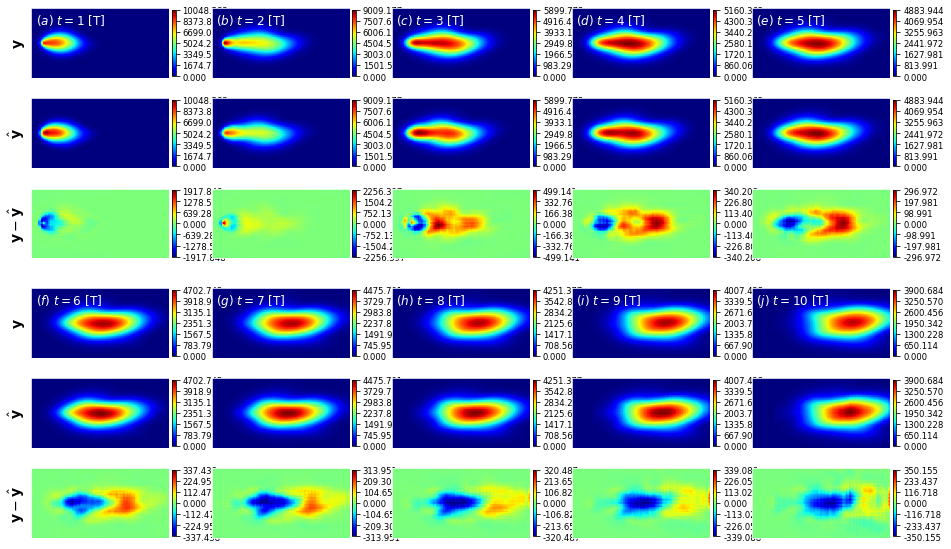

epoch 30, done with printing sample output 30
epoch: 30, test rmse_test:  157.013466
epoch: 35, test rmse_test:  170.179432
epoch: 40, test rmse_test:  150.858012
epoch: 45, test rmse_test:  153.529025
epoch: 50, test rmse_test:  155.378583
epoch: 55, test rmse_test:  159.429652
Epoch    62: reducing learning rate of group 0 to 2.5000e-03.


<Figure size 432x288 with 0 Axes>

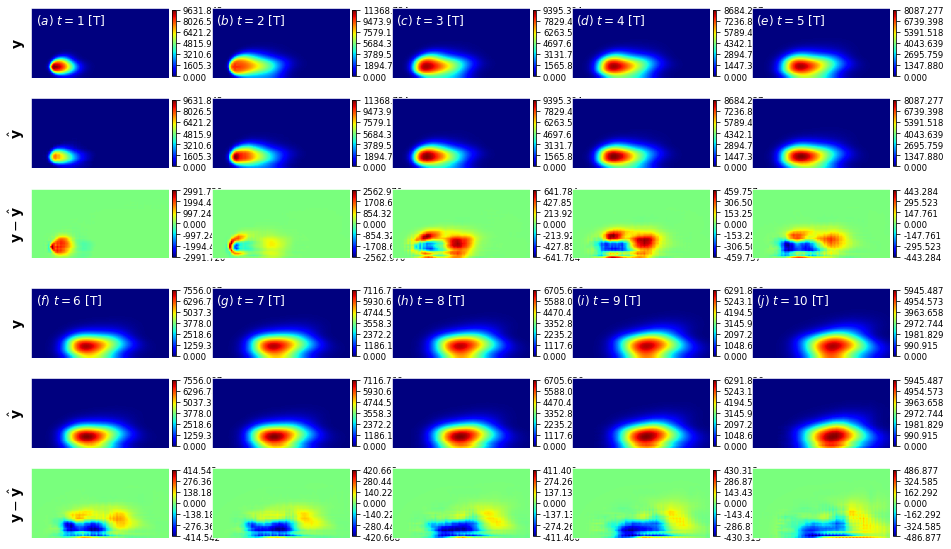

epoch 60, done with printing sample output 0
epoch: 60, test rmse_test:  153.733482
epoch: 65, test rmse_test:  146.984001
epoch: 70, test rmse_test:  147.144270
epoch: 75, test rmse_test:  144.084981
epoch: 80, test rmse_test:  146.612822
epoch: 85, test rmse_test:  152.937666
Epoch    94: reducing learning rate of group 0 to 1.2500e-03.


<Figure size 432x288 with 0 Axes>

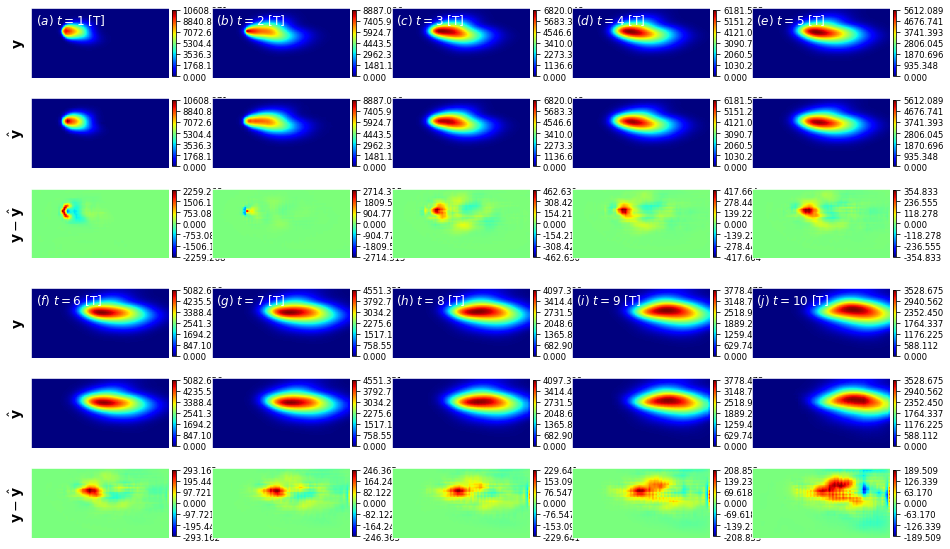

epoch 90, done with printing sample output 418
epoch: 90, test rmse_test:  142.886734
epoch: 95, test rmse_test:  142.576523
epoch: 100, test rmse_test:  141.576865
Epoch   107: reducing learning rate of group 0 to 6.2500e-04.
epoch: 105, test rmse_test:  141.097876
epoch: 110, test rmse_test:  140.877334
epoch: 115, test rmse_test:  141.368750


<Figure size 432x288 with 0 Axes>

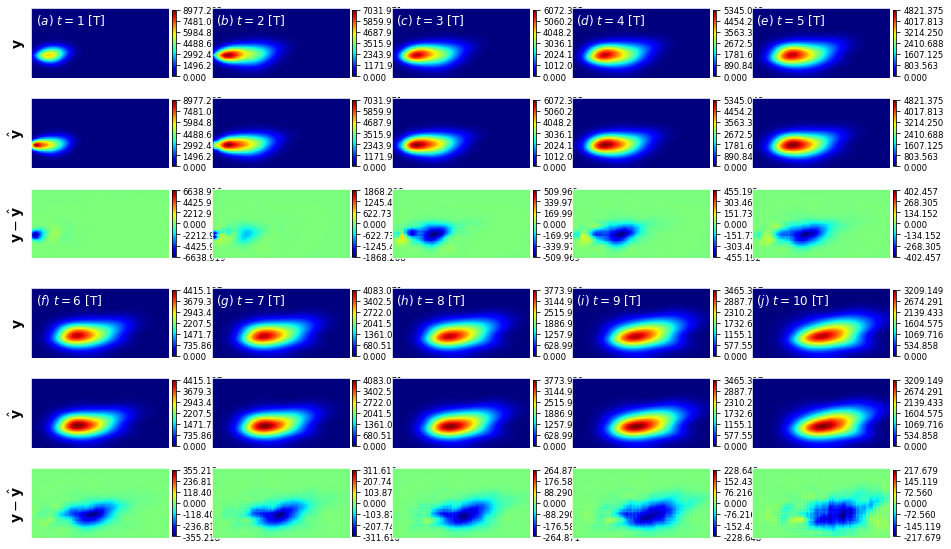

epoch 120, done with printing sample output 228
epoch: 120, test rmse_test:  140.753028
epoch: 125, test rmse_test:  141.157563
epoch: 130, test rmse_test:  140.475901
Epoch   138: reducing learning rate of group 0 to 3.1250e-04.
epoch: 135, test rmse_test:  140.952072
epoch: 140, test rmse_test:  140.802181
Epoch   149: reducing learning rate of group 0 to 1.5625e-04.
epoch: 145, test rmse_test:  140.072857


<Figure size 432x288 with 0 Axes>

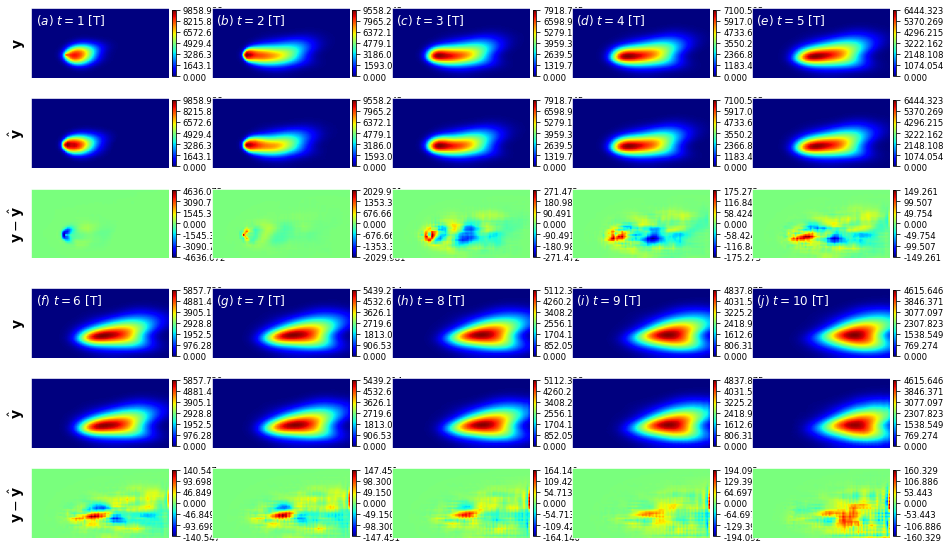

epoch 150, done with printing sample output 13
epoch: 150, test rmse_test:  139.849717
epoch: 155, test rmse_test:  140.508171
epoch: 160, test rmse_test:  139.749819
epoch: 165, test rmse_test:  140.068016
epoch: 170, test rmse_test:  140.356696
Epoch   175: reducing learning rate of group 0 to 7.8125e-05.
epoch: 175, test rmse_test:  139.705300


<Figure size 432x288 with 0 Axes>

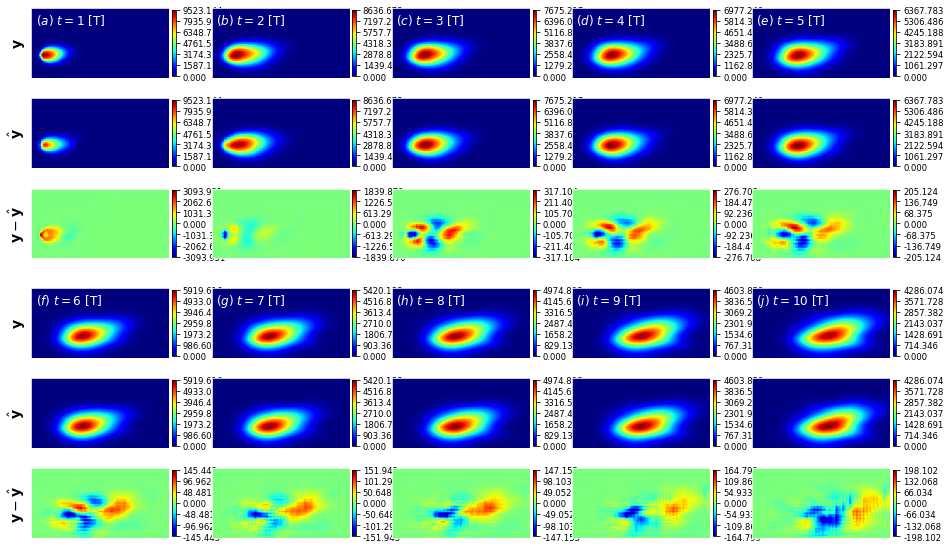

epoch 180, done with printing sample output 238
epoch: 180, test rmse_test:  139.622407
Epoch   186: reducing learning rate of group 0 to 3.9063e-05.
epoch: 185, test rmse_test:  139.774648
epoch: 190, test rmse_test:  139.762009
Epoch   197: reducing learning rate of group 0 to 1.9531e-05.
epoch: 195, test rmse_test:  140.237663
epoch: 200, test rmse_test:  139.869699
Epoch   208: reducing learning rate of group 0 to 9.7656e-06.
epoch: 205, test rmse_test:  139.568224


<Figure size 432x288 with 0 Axes>

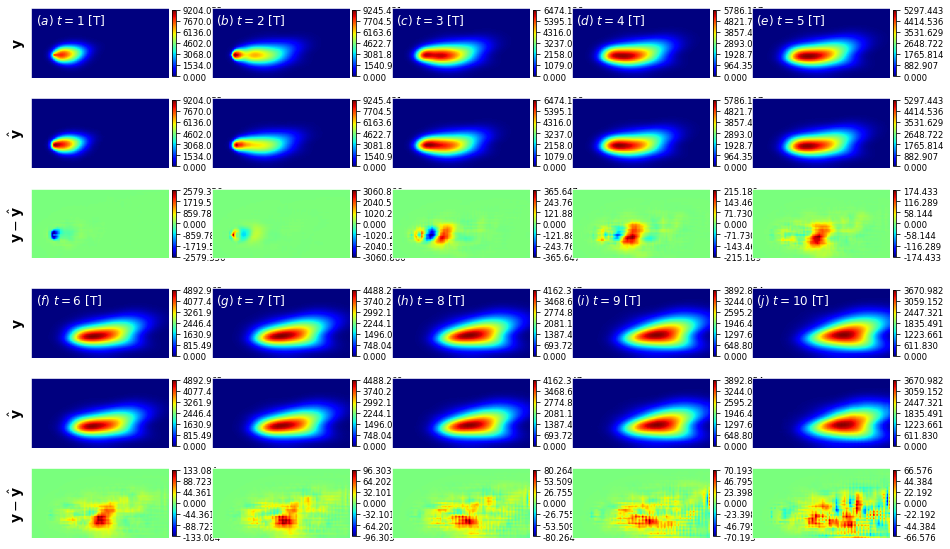

epoch 210, done with printing sample output 477
epoch: 210, test rmse_test:  139.586591
Epoch   219: reducing learning rate of group 0 to 4.8828e-06.
epoch: 215, test rmse_test:  139.643755
epoch: 220, test rmse_test:  139.579622
epoch: 225, test rmse_test:  139.567961
epoch: 230, test rmse_test:  140.134539
Epoch   239: reducing learning rate of group 0 to 2.4414e-06.
epoch: 235, test rmse_test:  139.533480


<Figure size 432x288 with 0 Axes>

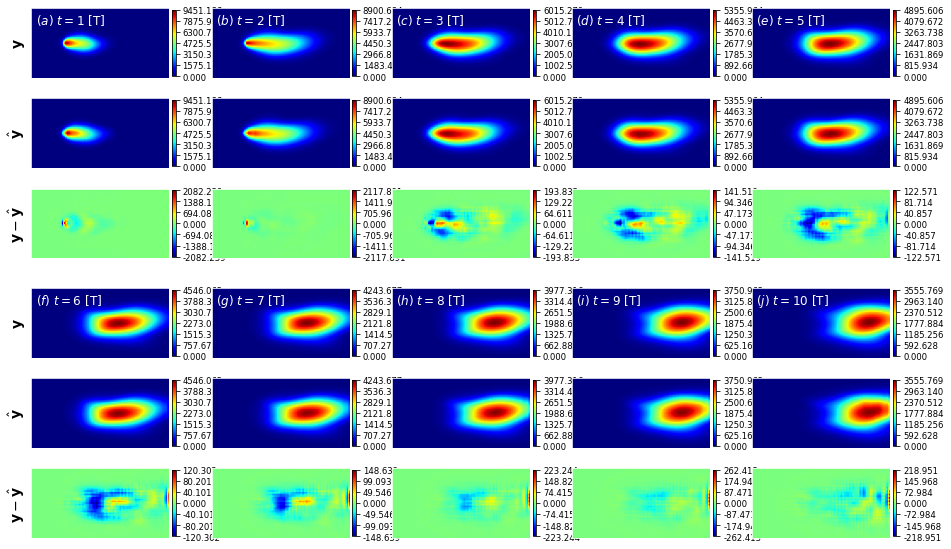

epoch 240, done with printing sample output 285
epoch: 240, test rmse_test:  140.139200
epoch: 245, test rmse_test:  139.692239
Epoch   250: reducing learning rate of group 0 to 1.2207e-06.
epoch: 250, test rmse_test:  139.900656
epoch: 255, test rmse_test:  140.070118
Epoch   261: reducing learning rate of group 0 to 6.1035e-07.
epoch: 260, test rmse_test:  139.675384
epoch: 265, test rmse_test:  139.602558
Epoch   272: reducing learning rate of group 0 to 3.0518e-07.


<Figure size 432x288 with 0 Axes>

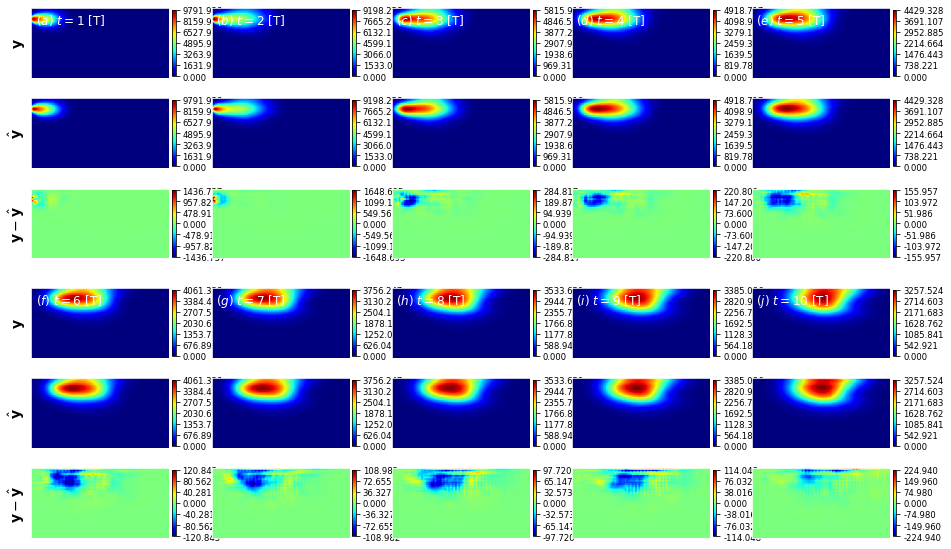

epoch 270, done with printing sample output 254
epoch: 270, test rmse_test:  139.637600
epoch: 275, test rmse_test:  139.594890
Epoch   283: reducing learning rate of group 0 to 1.5259e-07.
epoch: 280, test rmse_test:  139.667010
epoch: 285, test rmse_test:  139.602856
Epoch   294: reducing learning rate of group 0 to 7.6294e-08.
epoch: 290, test rmse_test:  139.556478
epoch: 295, test rmse_test:  140.350618


<Figure size 432x288 with 0 Axes>

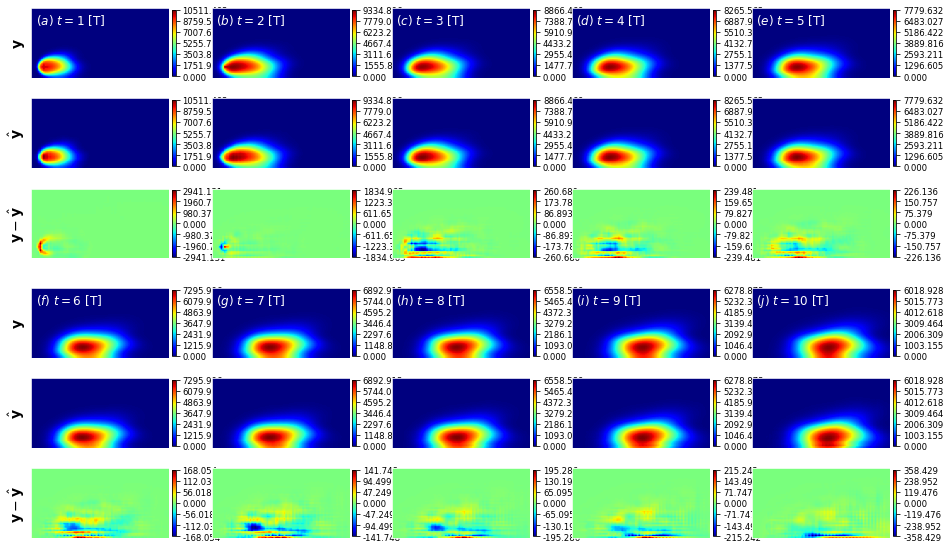

epoch 300, done with printing sample output 423
epoch: 300, test rmse_test:  139.597871
Done training 300 epochs with 1000 data using 2213.3538341522217 seconds


<Figure size 432x288 with 0 Axes>

In [74]:
n_epochs = 300
log_interval = 5
plot_interval = 30
rmse_train, rmse_test = [], []
w_s = 0.2
w_w = 0.1
tic = time.time()
model_dir = '/content/drive/My Drive/inverse_modeling/reactive_transport/net_files'
for epoch in range(1, n_epochs+1):
    model.train()
    mse = 0.
    for batch_idx, (input, target) in enumerate(train_loader):
        input, target= input.to(device), target.to(device)
        model.zero_grad()
        output = model(input)
        loss = F.l1_loss(output, target,reduction='sum')
        ##add additional loss near to the sensors
        loss += w_s * F.l1_loss(output[:,:,y_obs, x_obs], target[:,:,y_obs, x_obs], reduction='sum')
        loss += w_s * F.l1_loss(output[:,:,y_obs-1, x_obs], target[:,:,y_obs-1, x_obs], reduction='sum')
        loss += w_s * F.l1_loss(output[:,:,y_obs+1, x_obs], target[:,:,y_obs+1, x_obs], reduction='sum')
        loss += w_s * F.l1_loss(output[:,:,y_obs, x_obs-1], target[:,:,y_obs, x_obs-1], reduction='sum')
        loss += w_s * F.l1_loss(output[:,:,y_obs, x_obs-1], target[:,:,y_obs, x_obs-1], reduction='sum')
        ##add additional loss near to the wells candidates
        loss += w_w * F.l1_loss(output[:,:,y_wel, x_wel], target[:,:,y_wel, x_wel], reduction='sum')
        loss += w_w * F.l1_loss(output[:,:,y_wel-1, x_wel], target[:,:,y_wel-1, x_wel], reduction='sum')
        loss += w_w * F.l1_loss(output[:,:,y_wel+1, x_wel], target[:,:,y_wel+1, x_wel], reduction='sum')
        loss += w_w * F.l1_loss(output[:,:,y_wel, x_wel-1], target[:,:,y_wel, x_wel-1], reduction='sum')
        loss += w_w * F.l1_loss(output[:,:,y_wel, x_wel+1], target[:,:,y_wel, x_wel+1], reduction='sum')
        # loss = F.mse_loss(output, target,reduction='sum')
        loss.backward()
        optimizer.step()
        mse += F.mse_loss(output, target,reduction='sum').item()

    rmse = np.sqrt(mse / n_out_pixels_train)
    scheduler.step(rmse)

    if epoch % log_interval == 0:
        # r2_score = 1 - mse / y_train_var
        # print("epoch: {}, training r2-score: {:.4f}".format(epoch, r2_score))
        # r2_train.append(r2_score)
        rmse_train.append(rmse)
        rmse_t = test(epoch, plot_intv=plot_interval)
        # r2_test.append(r2_t)
        rmse_test.append(rmse_t)

    # save model
    if epoch == n_epochs:
        torch.save(model.state_dict(), model_dir + "/model_epoch{}.pth".format(epoch))

tic2 = time.time()
print("Done training {} epochs with {} data using {} seconds"
      .format(n_epochs, 1000, tic2 - tic))


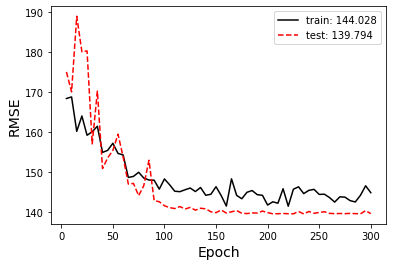

In [75]:
x = np.arange(log_interval, n_epochs + log_interval,
                log_interval)
plt.figure()
plt.plot(x, rmse_train, 'k', label="train: {:.3f}".format(np.mean(rmse_train[-5: -1])))
plt.plot(x, rmse_test, 'r', linestyle = '--', label="test: {:.3f}".format(np.mean(rmse_test[-5: -1])))
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.legend(loc='upper right')
plt.savefig('/content/drive/My Drive/inverse_modeling/reactive_transport/net_files/rmse.pdf')

#### diagnose the posterior of the test NN outputs and the PDE solutions.

In [0]:
with open('/content/drive/My Drive/inverse_modeling/Code/python_2d/nonlinear_10_20/sensor_i','rb') as file:
  sensor_i = pickle.load(file)

In [0]:
x_testF = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],-1))
y_testF = np.reshape(y_test,(y_test.shape[0],y_test.shape[1],-1))
test_map = np.concatenate((x_testF,y_testF),axis = 1)
test_sen = test_map[:,:,sensor_i]
NN_map = np.array([]).reshape(0,10,40,80)
model.eval()
for batch_idx, (input, target) in enumerate(test_loader):
    input, target = input.to(device), target.to(device)
    with torch.no_grad():
        output = model(input)
        output = output.cpu()
        output = output.numpy()
        NN_map = np.concatenate((NN_map,output),axis = 0)        

In [0]:
NN_map = np.concatenate((x_test,NN_map),axis = 1)
NN_map = np.reshape(NN_map,(NN_map.shape[0],NN_map.shape[1],-1))
NN_sen = NN_map[:,:,sensor_i]

0.00031935346695027785

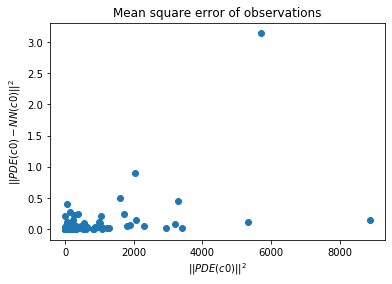

In [0]:
s_pde = []
s_nn = []
s_diff = []
per_s_diff = []
for i in range(NN_sen.shape[0]):
  s_pde.append(np.sum(test_sen[i]**2))
  s_nn.append(np.sum(NN_sen[i]**2))
  s_diff.append(np.sum((test_sen[i] - NN_sen[i])**2))
  per_s_diff.append(np.sum((test_sen[i] - NN_sen[i])**2)/np.sum(test_sen[i]**2))

plt.scatter(s_pde,s_diff)
plt.xlabel('$|| PDE(c0) ||^2 $')
plt.ylabel('$|| PDE(c0) - NN(c0) ||^2 $')
plt.show
plt.title("Mean square error of observations")
plt.savefig('diag_square.pdf'.format(),
                bbox_inches='tight')
# plt.close()

# plt.scatter(s_pde,per_s_diff)
# plt.xlabel('$|| PDE(c0) ||^2 $')
# plt.ylabel('$|| PDE(c0) - NN(c0)||^2/|| PDE(c0) ||^2$')
# plt.savefig('.pdf'.format(),
#                 bbox_inches='tight')
# plt.title('peak_1_value')
s_diff[0]

In [0]:
print('PDE sensors shape:',test_sen.shape)
print('NN sensors shape',NN_sen.shape)

PDE sensors shape: (400, 11, 20, 1)
NN sensors shape (400, 11, 20, 1)


PDE posterior shape: 400
NN posterior shape 400


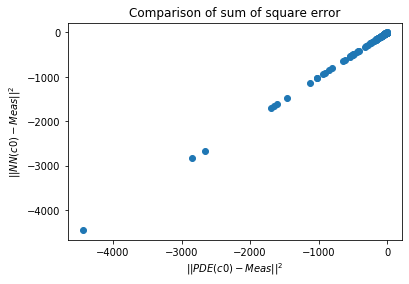

In [0]:
PDE_post = []
NN_post = []
def post(sensor,meas):
    #prior*likelihood
    #prior: centered at 5, standard deviation  = 1.25, s.t. 4 standard deviation bounds: [0, 10]
    #sig_prior = (5/4)**2
    #Mprior = 5
    #Rprior =  1/sig_prior
    #dc0 = c0_prop.value - Mprior
    #reg = 0.0000 #regularization parameter

    #likelihood
    sensor = np.reshape(sensor,(sensor.shape[0]*sensor.shape[1],))
    meas = np.reshape(meas,(meas.shape[0]*meas.shape[1],))
    sig_meas = 0.005**2
    sig_meas = 1
    R = 1/sig_meas
    dc = meas - sensor
    pos = -1/2*dc.T.dot(dc)*R # - reg/2*dc0.T.dot(dc0)*Rprior
    return pos

for i in range(NN_sen.shape[0]):
  PDE_post.append(post(test_sen[i,:,:,0],meas))
  NN_post.append(post(NN_sen[i,:,:,0],meas))

print('PDE posterior shape:',len(PDE_post))
print('NN posterior shape',len(NN_post))

plt.scatter(PDE_post,NN_post)
plt.xlabel('$|| PDE(c0) - Meas ||^2$')
plt.ylabel('$|| NN(c0) - Meas ||^2$')
plt.title("Comparison of sum of square error")
plt.show
plt.savefig('diag_L.pdf'.format(),
                bbox_inches='tight')

In [0]:
3/0.005**2*0.5

60000.0

within 100 diff 1.0


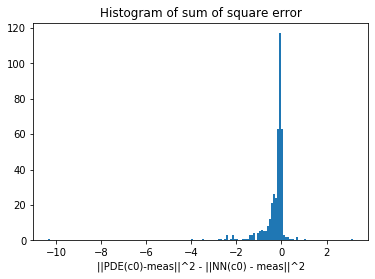

In [0]:
diff = [PDE_post[i] - NN_post[i] for i in range(len(NN_post))]
diff = np.asarray(diff)
# plt.plot(diff)
_ = plt.hist(diff, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of sum of square error")
plt.xlabel('||PDE(c0)-meas||^2 - ||NN(c0) - meas||^2')
# plt.ylabel('$$')
plt.show
plt.savefig('diag_d_L.pdf',bbox_inches='tight')
print('within 100 diff',np.mean([diff>-100] and [diff < 100]))
max_i = np.argmax(diff)
min_i = np.argmax(-diff)
best_i = np.argmin(np.abs(diff))

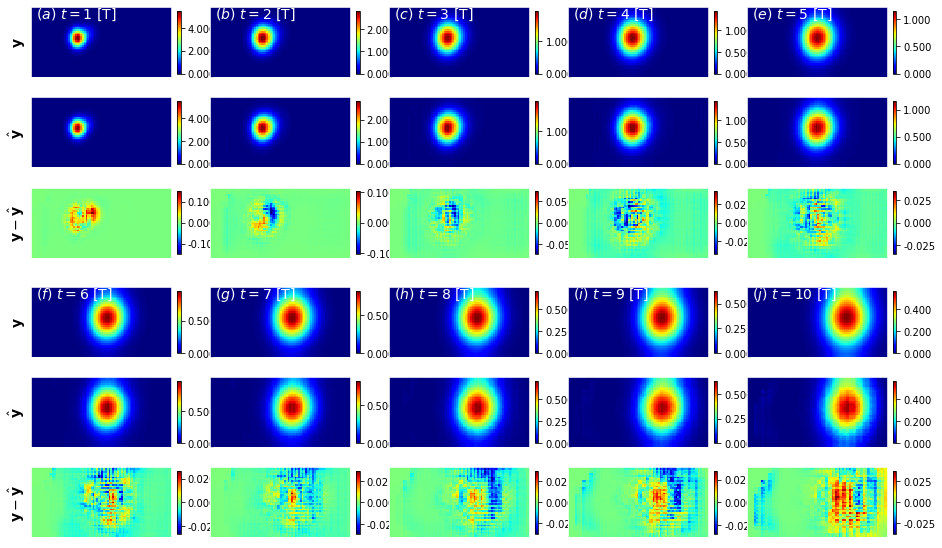

epoch 0, done with printing sample output 100


In [0]:
# idx = [min_i,max_i,best_i]
idx = [100]
model.eval()
epoch = 0
for i in range(len(idx)):
  x = x_test[ [idx[i]] ]
  samples_target = y_test[ idx[i] ]
  x_tensor = (torch.FloatTensor(x)).to(device)
  y_hat = model(x_tensor)
  samples_output = y_hat[0].data.cpu().numpy()
  plot_pred(samples_target, samples_output, epoch, idx[i])

In [0]:
files.download('/content/epoch_0_output_100.png') 

In [0]:
files.download('/content/epoch_0_output_0.png') 
files.download('/content/epoch_0_output_300.png') 

In [0]:
c0_prop = []
sensor_prop = []
with open('/content/drive/My Drive/inverse_modeling/Code/python_2d/1020/samples_not_on_grid','rb') as file:
  N = pickle.load(file)
  for i in range(N):
    [c0,sen] = pickle.load(file)
    c0_prop.append(c0)
    sensor_prop.append(sen)
print('length of c0_prop is',len(c0_prop))
print('length of sensor_prop is',len(sensor_prop)) 

length of c0_prop is 100000
length of sensor_prop is 100000


In [0]:
print('shape of c0_prop:',c0.shape)
print('shape of sensor_prop is',sen.shape) 

shape of c0_prop: (3200,)
shape of sensor_prop is (12, 20)


In [0]:
def NN_model(c0):
  c0_input = np.reshape(c0,(1,1,40,80))
  model.eval()
  x_tensor = (torch.FloatTensor(c0_input)).to(device)
  y_hat = model(x_tensor)
  samples_output = y_hat[0].data.cpu().numpy()
  sen_obser = sensor(c0,samples_output)
  return sen_obser
## take sensors observations 
def sensor(c0, cT):
  c0 = np.reshape(c0,(1,40*80))
  cT = np.reshape(cT,(11,40*80))
  c0cT = np.concatenate((c0,cT),axis =0)
  sen = np.reshape(c0cT[:,sensor_i],(12,20))
  return sen
## calculate the posterior numerator
def post(sensor,meas):
    #prior*likelihood
    #prior: centered at 5, standard deviation  = 1.25, s.t. 4 standard deviation bounds: [0, 10]
    #sig_prior = (5/4)**2
    #Mprior = 5
    #Rprior =  1/sig_prior
    #dc0 = c0_prop.value - Mprior
    #reg = 0.0001 #regularization parameter

    #likelihood
    sensor = np.reshape(sensor,(sensor.shape[0]*sensor.shape[1],))
    meas = np.reshape(meas,(meas.shape[0]*meas.shape[1],))
    sig_meas = 0.005**2
    R = 1/sig_meas
    dc = meas - sensor
    pos = -1/2*dc.T.dot(dc)*R # - reg/2*dc0.T.dot(dc0)*Rprior
    return pos

p_prop_nn = []
p_prop_pde = []
for i in range(N):
  sen_obser = NN_model(c0_prop[i])
  p_prop_nn.append(post(sen_obser,meas))
  p_prop_pde.append(post(sensor_prop[i],meas))
print('length of p_prop_nn is',len(p_prop_nn))
print('length of p_prop_pde is',len(p_prop_pde)) 

length of p_prop_nn is 100000
length of p_prop_pde is 100000


In [0]:
diff_pde = np.asarray([p_prop_pde[i+1] - p_prop_pde[i] for i in range(len(p_prop_pde) - 1)])
smaller_prop = diff_pde < 0
larger_prop = diff_pde > 0 
same_prop = diff_pde == 0 
print('smaller posterior samples:', np.sum(smaller_prop))
print('larger posterior samples:', np.sum(larger_prop))
print('same posterior samples:', np.sum(same_prop))
print(diff_pde[smaller_prop])

smaller posterior samples: 20
larger posterior samples: 119
same posterior samples: 99860
[-2.95881152e+03 -1.89580190e+04 -1.21088147e+04 -7.89400172e+01
 -5.92017473e+03 -3.50806470e+02 -1.61364823e+01 -5.90606923e+03
 -4.35716121e+02 -2.71597884e+04 -1.61081019e+03 -1.48786573e+03
 -3.47997420e+03 -1.85664502e+03 -5.74180110e+03 -4.19315938e+02
 -3.42226538e+03 -2.35032137e+03 -5.06674582e+02 -1.00013870e+03]


In [0]:
diff_nn = np.asarray([p_prop_nn[i+1] - p_prop_nn[i] for i in range(len(p_prop_nn) - 1)])
smaller_prop = diff_nn < 0
larger_prop = diff_nn > 0 
same_prop = diff_nn == 0 
print('smaller posterior samples:', np.sum(smaller_prop))
print('larger posterior samples:', np.sum(larger_prop))
print('same posterior samples:', np.sum(same_prop))
print(diff_nn[smaller_prop])

smaller posterior samples: 23314
larger posterior samples: 23370
same posterior samples: 53315
[-1.30302506e-05 -3.42440326e-05 -3.30922194e-06 ... -1.39200929e-05
 -1.49648422e-05 -1.39200929e-05]


# Archived attempts by myself

###Fully connect neural network, 

lr 1.000000e-03 reg 1.000000e-04 decay_r 8.000000e-01 h_size 8.000000e+02 decay_s 5.000000e+02 train_loss: 0.006676 val loss: 0.673232)
The best validation accuracy is 0.673232


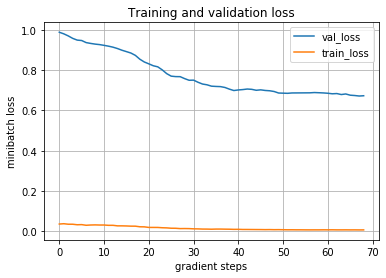

In [0]:
# initial_learning_rate = 1e-3
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=1000,
#     decay_rate=0.8,
#     staircase=True)
# regu = 1e-4
# hidden_layer_size = 800

def fc_model_init_fn():
    input_shape = (3200,)
    out_size, out_shape = 11*3200, (3200,11)
    initializer = tf.initializers.VarianceScaling(scale=2.0)
    layers = [
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(hidden_layer_size, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(regu),
                              kernel_initializer=initializer),
        tf.keras.layers.Dense(hidden_layer_size, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(regu),
                              kernel_initializer=initializer),
        tf.keras.layers.Dense(hidden_layer_size, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(regu),
                              kernel_initializer=initializer),              
        tf.keras.layers.Dense(out_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regu),
                              kernel_initializer=initializer),
        tf.keras.layers.Reshape(target_shape= out_shape),
    ]
    model = tf.keras.Sequential(layers)
    return model

def optimizer_init_fn():
    return tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)


best_loss = 100
best_train_loss = 100
best_model = None
lr_rate = [1e-3]
regu_weight = [1e-4]
decay_rs = [0.8]
hidden_size = [800]
decay_steps = [500]
results = {}
best_result = None
for initial_learning_rate in lr_rate:
  for regu in regu_weight:
    for decay_r in decay_rs:
      for hidden_layer_size in hidden_size:
        for decay_step in decay_steps:
          decay_step = decay_step
          regu = regu
          decay_r = decay_r
          initial_learning_rate = initial_learning_rate
          hidden_layer_size = hidden_layer_size
          lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
              initial_learning_rate,
              decay_steps=decay_step,
              decay_rate=decay_r,
              staircase=True)
          fc_model = fc_model_init_fn()
          [val_losses, train_losses] = train(fc_model, optimizer_init_fn)
          results[initial_learning_rate,regu,decay_r,hidden_layer_size,decay_step] = (train_losses[-1],val_losses[-1])
          if val_losses[-1] < best_loss:
            best_loss = val_losses[-1]
            best_model = fc_model
            best_result = [initial_learning_rate, regu, decay_r, hidden_layer_size,decay_step]
          if train_losses[-1] < best_train_loss:
            best_train_loss = train_losses[-1]

for lr, reg, decay_r, h_size, decay_s in sorted(results):
  (train_loss, val_loss) = results[(lr, reg, decay_r, h_size, decay_s)]
  print('lr %e reg %e decay_r %e h_size %e decay_s %e train_loss: %f val loss: %f)' % (
          lr, reg, decay_r, h_size, decay_s, train_loss, val_loss))
  
print('The best validation accuracy is %f'%(best_loss))
plt.plot(val_losses[1:],label = 'val_loss')
plt.plot(train_losses[1:],label = 'train_loss')
plt.grid(True)
plt.title('Training and validation loss')
plt.xlabel('gradient steps')
plt.ylabel('minibatch loss')
plt.legend(loc='upper right')
plt.show()

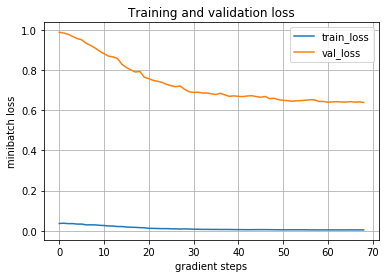

In [0]:
plt.plot(train_losses[1:],label = 'train_loss')
plt.plot(val_losses[1:],label = 'val_loss')
plt.grid(True)
plt.title('Training and validation loss')
plt.xlabel('gradient steps')
plt.ylabel('minibatch loss')
plt.legend(loc='upper right')
plt.show()

In [0]:
fc_model.summary()

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_56 (Flatten)         (None, 3200)              0         
_________________________________________________________________
dense_228 (Dense)            (None, 800)               2560800   
_________________________________________________________________
dense_229 (Dense)            (None, 800)               640800    
_________________________________________________________________
dense_230 (Dense)            (None, 800)               640800    
_________________________________________________________________
dense_231 (Dense)            (None, 35200)             28195200  
_________________________________________________________________
reshape_103 (Reshape)        (None, 3200, 11)          0         
Total params: 32,037,600
Trainable params: 32,037,600
Non-trainable params: 0
_________________________________________

In [0]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_loss.reset_states()
for test_x, test_y in test_dset:
  # During validation at end of epoch, training set to False
  prediction = fc_model(test_x, training=False)
  t_loss = relaloss(test_y, prediction)
  test_loss.update_state(t_loss)

print('test loss is', test_loss.result())

test loss is tf.Tensor(0.71764755, shape=(), dtype=float32)


each modeling time is 0.012316226959228516
relative test loss is tf.Tensor(1.6927588, shape=(), dtype=float32)


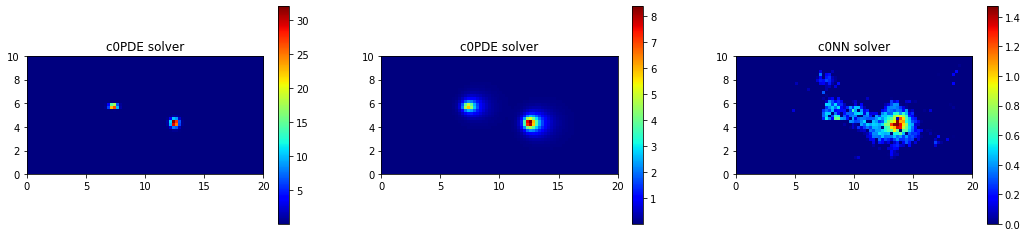

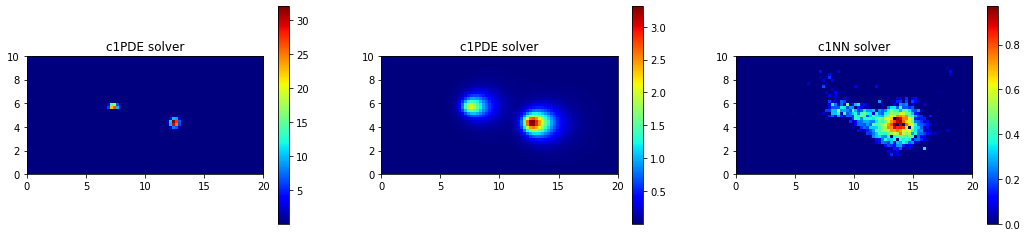

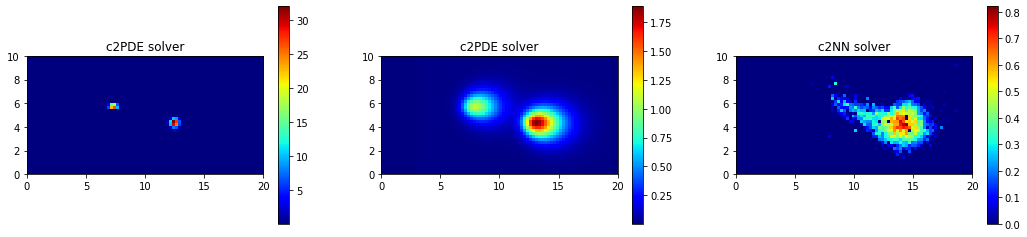

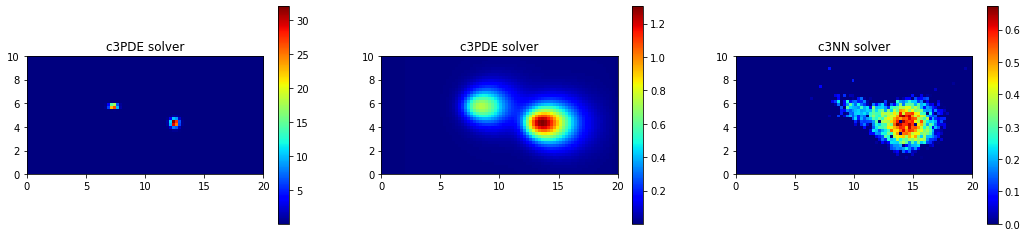

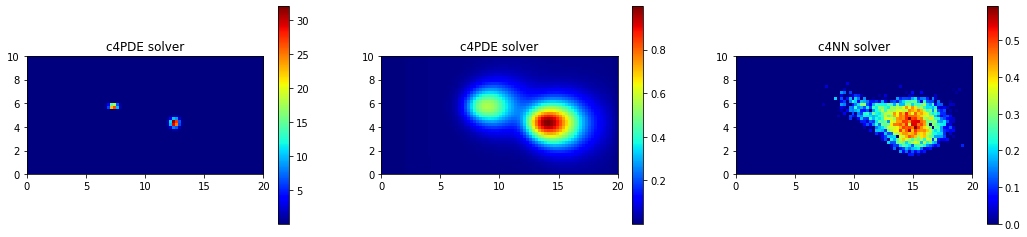

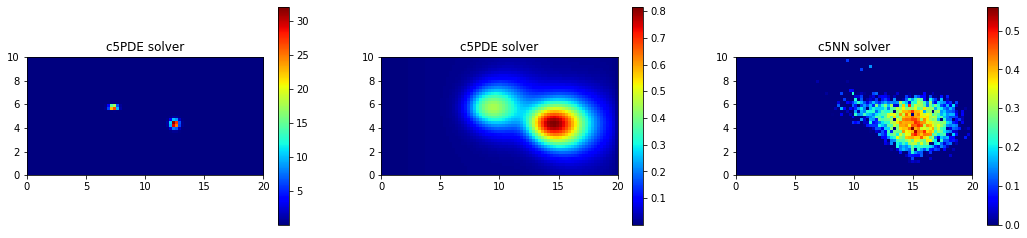

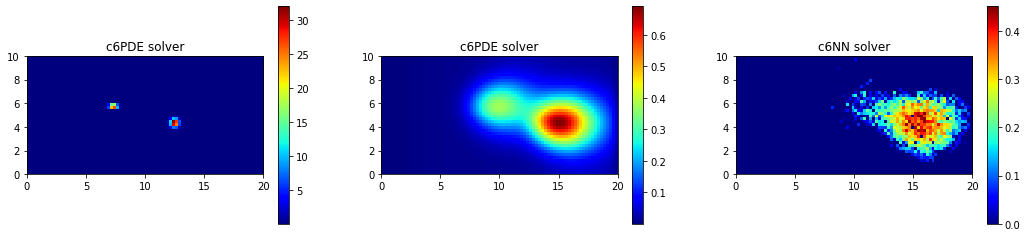

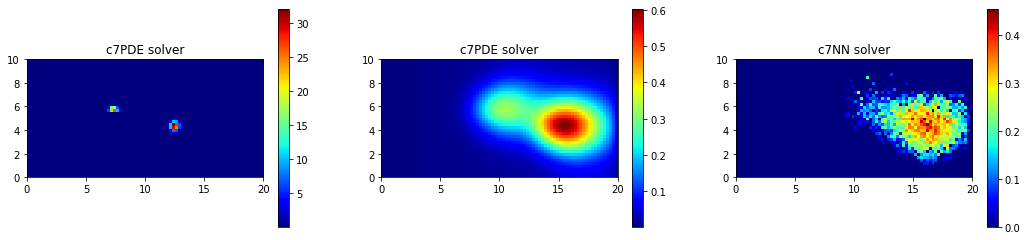

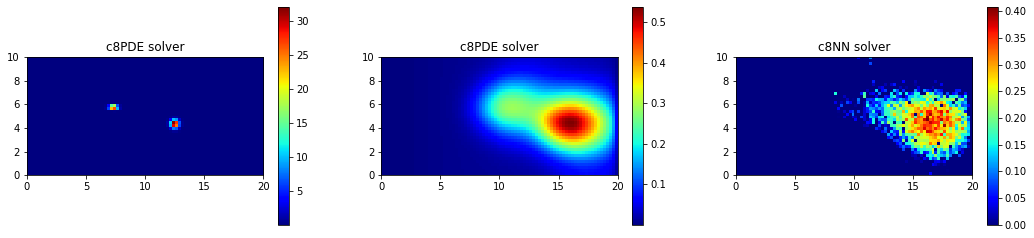

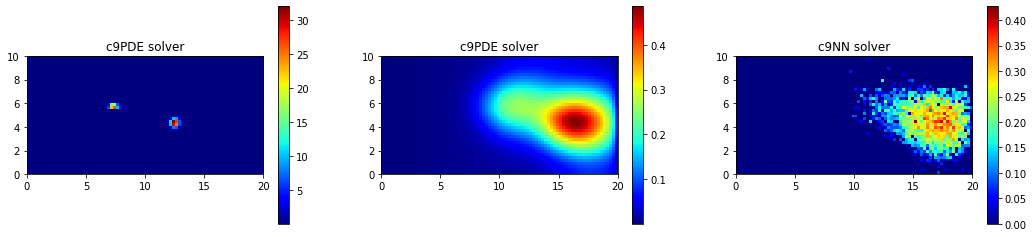

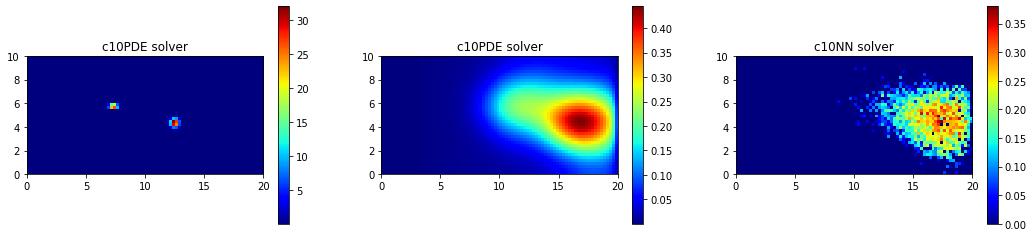

In [0]:
random_test(fc_model)

In [0]:
fc_model.save('/fc_model.h5')  # creates a HDF5 file 'my_model.h5'
del fc_model  # deletes the existing model

# returns a compiled model
# identical to the previous one
fc_model = tf.keras.models.load_model('/content/fc_model.h5',compile=False)

### Convolutional neural network, c0[3200,] --> cT[3200,11]

In [0]:
del cnn_model

training time is 20.717745780944824 s


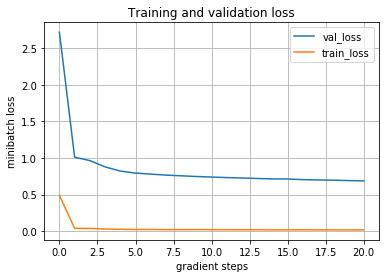

In [0]:
learning_rate = 5e-4
# initial_learning_rate = 1e-4
# learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=40,
#     decay_rate=0.8,
#     staircase=True)

regu = 3e-4
channel_1 = 32
channel_2 = 64
hidden_size = 100
def cnn_model_init_fn():
    training = True
    input_shape = (3200,)
    out_size = 11*3200
    initializer = tf.initializers.VarianceScaling(scale=2.0)
    layers = [
        tf.keras.layers.Reshape(input_shape=input_shape, target_shape=(40,80,1)),
        tf.keras.layers.Conv2D(channel_1, kernel_size = 3, padding="same", use_bias = True,
                      # kernel_regularizer=tf.keras.regularizers.l2(regu),
                      kernel_initializer=initializer),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(channel_2, kernel_size = 3, padding="same", use_bias = True,
                      # kernel_regularizer=tf.keras.regularizers.l2(regu),
                      kernel_initializer=initializer),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.UpSampling2D(2),
        tf.keras.layers.Conv2DTranspose(
              filters=channel_2,
              kernel_size=2,
              strides=(1, 1),
              padding="SAME",
              activation='relu'),
        tf.keras.layers.UpSampling2D(2),
        tf.keras.layers.Conv2DTranspose(
              filters=channel_2,
              kernel_size=2,
              strides=(1, 1),
              padding="SAME",
              activation='relu'),
        # tf.keras.layers.Flatten(),
        # tf.keras.layers.Dense(hidden_size, activation='relu', kernel_initializer=initializer,
        #                       kernel_regularizer=tf.keras.regularizers.l2(regu),),
        # tf.keras.layers.Dense(hidden_size, activation='relu', kernel_initializer=initializer,
        #                       kernel_regularizer=tf.keras.regularizers.l2(regu),),
        # tf.keras.layers.Dense(out_size, activation='relu', kernel_initializer=initializer,
        #                       kernel_regularizer=tf.keras.regularizers.l2(regu),),
        tf.keras.layers.Conv2D(
              filters=11, kernel_size=2, padding="SAME",activation='relu'),
        tf.keras.layers.Reshape(target_shape=(3200,11)),
    ]
    model = tf.keras.Sequential(layers)
    return model

cnn_model = cnn_model_init_fn()

def optimizer_init_fn():
    return tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)
    # amsgrad = false is better, learning rate 0.001 better than 0.01
start = time.time()
val_losses, train_losses = train(cnn_model, optimizer_init_fn)
print('training time is', time.time() - start, 's')

plt.plot(val_losses,label = 'val_loss')
plt.plot(train_losses,label = 'train_loss')
plt.grid(True)
plt.title('Training and validation loss')
plt.xlabel('gradient steps')
plt.ylabel('minibatch loss')
plt.legend(loc='upper right')
plt.show()

In [0]:
cnn_model.summary()

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_89 (Reshape)         (None, 40, 80, 1)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 40, 80, 32)        320       
_________________________________________________________________
re_lu_40 (ReLU)              (None, 40, 80, 32)        0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 20, 40, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 20, 40, 64)        18496     
_________________________________________________________________
re_lu_41 (ReLU)              (None, 20, 40, 64)        0         
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 10, 20, 64)      

In [0]:
random_test(cnn_model)

##c0(3200,) --> cT[1,:] (3200,) --> cT[1,:] (3200,) --> ... -->cT[11,:] (3200,)

## data spliting, can make 11*sampleset samples from the dataset.

In [0]:
#C0s, CTs()
S_c0 = []
S_ct = []
for i in range(400):
  S_c0.append(C0s[i])
  S_ct.append(CTs[i][0,:])
  for j in range(sample_dim-1):
    S_c0.append(CTs[i][j])
    S_ct.append(CTs[i][j+1])
print('S_c0:',len(S_c0))
print('S_ct:',len(S_ct))
# S_ct[1].shape
S_c0[0].shape

S_c0: 4400
S_ct: 4400


(3200,)

In [0]:
def load_c(output,num_training=int(len(S_c0)*0.7), num_validation=int(len(S_c0)*0.15), num_test=int(len(S_c0)*0.15)):
  """
  load training data from the pickled list: C0s, CTs, sensors, divide the training, validation, and num_test to 7:1.5:1.5
  """
  # turn C0s, CTs, as samples
  X_train = S_c0
  y_train = S_ct
  X_train = np.asarray(X_train, dtype=np.float32)
  y_train = np.asarray(y_train, dtype=np.float32)
  # y_train = np.transpose(y_train, (0,2,1))

  # Subsample the data
  mask = range(num_training + num_validation, num_training + num_validation + num_test)
  X_test = X_train[mask]
  y_test = y_train[mask]
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_c(output = S_ct)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

train_dset = Dataset(X_train, y_train, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=False)
test_dset = Dataset(X_test, y_test, batch_size=64)

Train data shape:  (3080, 3200)
Train labels shape:  (3080, 3200) float32
Validation data shape:  (660, 3200)
Validation labels shape:  (660, 3200)
Test data shape:  (660, 3200)
Test labels shape:  (660, 3200)


##Convolutional neural network

In [0]:
channel_1 = 4
channel_2 = 8
channel_3 = 16
hidden4 = 512

learning_rate = 1e-3

def cnn_model_init_fn():
    input_shape = (3200,)
    out_size, out_shape = 3200, (3200,)
    initializer = tf.initializers.VarianceScaling(scale=2.0)
    layers = [
        # tf.keras.layers.Reshape(input_shape=input_shape, target_shape=(40,80,1)),
        # tf.keras.layers.Conv2D(channel_1, kernel_size = 3, padding="same", use_bias = True,
        #               # kernel_regularizer=tf.keras.regularizers.l2(regu),
        #               kernel_initializer=initializer),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.ReLU(),
        # tf.keras.layers.MaxPooling2D((2, 2)),

        # tf.keras.layers.Conv2D(channel_2, kernel_size = 3, padding="SAME", use_bias = True,
        #               # kernel_regularizer=tf.keras.regularizers.l2(regu),
        #               kernel_initializer=initializer),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.ReLU(),
        # tf.keras.layers.MaxPooling2D((2, 2)),

        # tf.keras.layers.Conv2D(channel_3, kernel_size = 3, padding="SAME", use_bias = True,
        #               # kernel_regularizer=tf.keras.regularizers.l2(regu),
        #               kernel_initializer=initializer),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.ReLU(),
        # tf.keras.layers.MaxPooling2D((2, 2)),

        # tf.keras.layers.Flatten(),
        # tf.keras.layers.Dense(hidden4, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regu),
        #                       kernel_initializer=initializer),
        tf.keras.layers.Dense(out_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regu),
                              kernel_initializer=initializer),
        # tf.keras.layers.Reshape(target_shape=(3200,)),
    ]
    model = tf.keras.Sequential(layers)
    return model

def optimizer_init_fn():
    return tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)

cnn_model = cnn_model_init_fn()

start = time.time()
val_losses, train_losses = train(cnn_model, optimizer_init_fn)
print('training time is', time.time() - start, 's')

plt.plot(val_losses,label = 'val_loss')
plt.plot(train_losses,label = 'train_loss')
plt.grid(True)
plt.title('Training and validation loss')
plt.xlabel('gradient steps')
plt.ylabel('minibatch loss')
plt.legend(loc='upper right')
plt.show()

InvalidArgumentError: ignored

In [0]:
cnn_model.summary()

Model: "sequential_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_97 (Flatten)         multiple                  0         
_________________________________________________________________
dense_312 (Dense)            multiple                  10243200  
_________________________________________________________________
reshape_162 (Reshape)        multiple                  0         
Total params: 10,243,200
Trainable params: 10,243,200
Non-trainable params: 0
_________________________________________________________________


## c0 --> sensors(12,20)

make dataset with the sensors model states.

In [0]:
X_train, y_train, X_val, y_val, X_test, y_test = load_c(output = sensors)
train_dset = Dataset(X_train, y_train, batch_size=512, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=512, shuffle=False)
test_dset = Dataset(X_test, y_test, batch_size=512)

Fully connect neural network

In [0]:
# initial_learning_rate = 1e-3
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=1000,
#     decay_rate=1,
#     staircase=True)
# regu = 3e-3

def fc_model_init_fn():
    input_shape = (3200,)
    out_size, out_shape = 12*20, (12,20)
    initializer = tf.initializers.VarianceScaling(scale=2.0)
    layers = [
        # tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Reshape(input_shape=input_shape, target_shape=(40,80,1)),
        tf.keras.layers.Conv2D(4, kernel_size = 5, padding="same", use_bias = True,
                      # kernel_regularizer=tf.keras.regularizers.l2(regu),
                      kernel_initializer=initializer),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(8, kernel_size = 5, padding="same", use_bias = True,
                      # kernel_regularizer=tf.keras.regularizers.l2(regu),
                      kernel_initializer=initializer),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        # tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hidden_layer_size, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(regu),
                              kernel_initializer=initializer),
        tf.keras.layers.Dense(hidden_layer_size, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(regu),
                              kernel_initializer=initializer),
        # tf.keras.layers.Dense(hidden_layer_size, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(regu),
        #                       kernel_initializer=initializer),              
        tf.keras.layers.Dense(out_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regu),
                              kernel_initializer=initializer),
        tf.keras.layers.Reshape(target_shape= out_shape),
    ]
    model = tf.keras.Sequential(layers)
    return model

def optimizer_init_fn():
    return tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)
    # amsgrad = false is better, learning rate 0.001 better than 0.01


best_loss = 100
best_model = None
lr_rate = [1e-4,5e-4,1e-3,5e-3]
regu_weight = [1e-4,5e-4,1e-3,5e-3]
decay_rs = [0.8,1]
hidden_size = [100, 400, 800]
results = {}
best_result = None
for initial_learning_rate in lr_rate:
  for regu in regu_weight:
    for decay_r in decay_rs:
      for hidden_layer_size in hidden_size:
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=1000,
            decay_rate=decay_r,
            staircase=True)
        fc_model = fc_model_init_fn()
        [val_losses, train_losses] = train(fc_model, optimizer_init_fn)
        results[initial_learning_rate,regu,decay_r,hidden_layer_size] = (val_losses[-1])
        if val_losses[-1] < best_loss:
          best_loss = val_losses[-1]
          best_model = fc_model
          best_result = [initial_learning_rate, regu, decay_r, hidden_layer_size]
for lr, reg, decay_r, h_size in sorted(results):
  val_loss = results[(lr, reg, decay_r, h_size)]
  print('lr %e reg %e decay_r %e h_size %e val loss: %f' % (
          lr, reg, decay_r, h_size, val_loss))
  
print('The best validation accuracy is %f'%(best_loss))
# start = time.time()
# fc_model = fc_model_init_fn()
# val_losses, train_losses = train(fc_model, optimizer_init_fn)
# print('training time is', time.time() - start, 's')

# test_loss = tf.keras.metrics.Mean(name='test_loss')
# test_loss.reset_states()
# for test_x, test_y in test_dset:
#   # During validation at end of epoch, training set to False
#   prediction = fc_model(test_x, training=False)
#   t_loss = relaloss(test_y, prediction)
#   test_loss.update_state(t_loss)

# plt.plot(val_losses,label = 'val_loss')
# plt.plot(train_losses,label = 'train_loss')
# plt.grid(True)
# plt.title('Training and validation loss')
# plt.xlabel('gradient steps')
# plt.ylabel('minibatch loss')
# plt.legend(loc='upper right')
# plt.show()

lr 1.000000e-04 reg 1.000000e-04 decay_r 8.000000e-01 h_size 1.000000e+02 val loss: 0.949445
lr 1.000000e-04 reg 1.000000e-04 decay_r 8.000000e-01 h_size 4.000000e+02 val loss: 0.859619
lr 1.000000e-04 reg 1.000000e-04 decay_r 8.000000e-01 h_size 8.000000e+02 val loss: 0.759846
lr 1.000000e-04 reg 1.000000e-04 decay_r 1.000000e+00 h_size 1.000000e+02 val loss: 0.967874
lr 1.000000e-04 reg 1.000000e-04 decay_r 1.000000e+00 h_size 4.000000e+02 val loss: 0.856808
lr 1.000000e-04 reg 1.000000e-04 decay_r 1.000000e+00 h_size 8.000000e+02 val loss: 0.890109
lr 1.000000e-04 reg 5.000000e-04 decay_r 8.000000e-01 h_size 1.000000e+02 val loss: 0.984768
lr 1.000000e-04 reg 5.000000e-04 decay_r 8.000000e-01 h_size 4.000000e+02 val loss: 0.793514
lr 1.000000e-04 reg 5.000000e-04 decay_r 8.000000e-01 h_size 8.000000e+02 val loss: 0.755447
lr 1.000000e-04 reg 5.000000e-04 decay_r 1.000000e+00 h_size 1.000000e+02 val loss: 0.960901
lr 1.000000e-04 reg 5.000000e-04 decay_r 1.000000e+00 h_size 4.000000e

In [0]:
fc_model.summary()
#lr 1.000000e-03 reg 1.000000e-04 decay_r 1.000000e+00 h_size 1.000000e+02 val loss: 0.604426

NameError: ignored